In [1]:
# --- IMPORTS

import numpy as np
import random
import matplotlib.pyplot as plt
import os
import time

import cProfile

start_time = time.time()
random.seed(42) 
np.random.seed(42)

In [2]:
# --- CLASSES

class Gibbs:
    def __init__(self, size):
        self.size = size
        self.base_lambda = 1/size
    
    def get_distribution(self, num_trials, W, b):
        pass
    
    def plot_distribution(self, num_trials, W, b):
        plt.bar(np.arange(0, 2**self.size), self.get_distribution(num_trials, W, b))
        plt.show()
        
    def state_to_int(self, s):
        binary = [0 if i == -1 else 1 for i in s]
        result = 0
        power_of_two = 1
        for bit in reversed(binary):
            result += power_of_two * bit
            power_of_two *= 2
        return result
    
class Discrete_Gibbs(Gibbs):
    def get_distribution(self, num_trials, W, b):
        s = [random.choice([-1, 1]) for i in range(self.size)]
        result = np.zeros(2**self.size)
        for k in range(num_trials):
            for i in range(self.size):
                summation = np.dot(W[i], s)
                s[i] = np.sign(np.tanh(summation + b[i]) + random.uniform(-1, 1))
                result[self.state_to_int(s)] += 1
        return result
    
class Continuous_Gibbs(Gibbs):
    def get_distribution(self, num_trials, W, b):
        s = [random.choice([-1, 1]) for i in range(self.size)]
        result = dict()
        lambdas = [self.base_lambda] * self.size
        for k in range(num_trials):
            # competing exponentials
            times = [-np.log(1-np.random.uniform(0,1))/lambdas[i] for i in range(self.size)]

            # update the s[i] of the exponential that hit first
            argmin_time = np.argmin(times)
            if self.state_to_int(s) not in result:
                result[self.state_to_int(s)] = 0
            result[self.state_to_int(s)] += times[argmin_time]
            s[argmin_time] = -s[argmin_time]

            # update summation, sigmoid, and lambdas
            sigmoids = np.multiply(np.add(np.tanh(np.add(np.matmul(s, W), b)), 1), 0.5)
            lambdas = [(1-sigmoids[i])*self.base_lambda if s[i] == 1 else sigmoids[i]*self.base_lambda for i in range(self.size)]
        return result
    
class Max_Cut_Approximator(Continuous_Gibbs):
    def get_cut_sizes(self, num_trials, W, b, step_size):
        s = [random.choice([-1, 1]) for i in range(self.size)]
        result = dict()
        lambdas = [self.base_lambda] * self.size
        
        cuts = []
        for k in range(num_trials):
            # competing exponentials
            times = [-np.log(1-np.random.uniform(0,1))/lambdas[i] for i in range(self.size)]

            # update the s[i] of the exponential that hit first
            argmin_time = np.argmin(times)
            if self.state_to_int(s) not in result:
                result[self.state_to_int(s)] = 0
            result[self.state_to_int(s)] += times[argmin_time]
            s[argmin_time] = -s[argmin_time]

            # update summation, sigmoid, and lambdas
            sigmoids = np.multiply(np.add(np.tanh(np.add(np.matmul(s, W), b)), 1), 0.5)
            lambdas = [(1-sigmoids[i])*self.base_lambda if s[i] == 1 else sigmoids[i]*self.base_lambda for i in range(self.size)]
            
            if k % step_size == 0:
                best_state = max(result, key=result.get)
                binary = [-1 if i == 0 else 1 for i in list(map(int, bin(best_state)[2:]))]
                with_zeros = [-1] * (self.size - len(binary)) + binary
                cuts += [(k, self.cut_size(W, with_zeros))]
        
        return cuts
    

    def cut_size(self, W, joint_state):
        num_vertices = len(W)
        
        # calculate cut
        cut = 0
        for i in range(num_vertices):
            outgoing_edges = W[i]
            for j in range(len(outgoing_edges)):
                if outgoing_edges[j] != 0: # edge exists between vertex i and vertex j
                    if joint_state[i] != joint_state[j]: # on different sides of the cut
                        cut += 1
        return cut

In [3]:
# FUNCTIONS

def max_cut(file_name, num_repetitions, num_trials):
    file1 = open(file_name,"r") 
    arr = file1.readline()[:-1].split("\t") # first line
    num_vertices = int(arr[0])

    W = np.zeros((num_vertices, num_vertices))

    for line in file1:
        arr = line[:-1].split("\t")
        ind1 = int(arr[0])
        ind2 = int(arr[1])
        ind3 = int(arr[2])
        W[ind1-1][ind2-1] = ind3
    
    cg = Max_Cut_Approximator(num_vertices)
    b = np.zeros(num_vertices)

    result = []
    for _ in range(num_repetitions):
        dist = cg.get_distribution(num_trials, -0.5*W, b)
        best_state = np.argmax(dist)
        binary = [-1 if i == 0 else 1 for i in list(map(int, bin(best_state)[2:]))]
        with_zeros = [-1] * (num_vertices - len(binary)) + binary
        # calculate Hamiltonian
        H = 0
        for i in range(num_vertices):
            for j in range(num_vertices):
                H -= 2 * -W[i][j] * with_zeros[i] * with_zeros[j] # J = -W[i][j]

        cut = cg.cut_size(W, with_zeros)

        result += [(best_state, H, cut)]
    return result
    
def plot_max_cut_efficiency(file_name, num_trials, step_size):
    file1 = open(file_name,"r") 
    arr = file1.readline()[:-1].split("\t") # first line
    num_vertices = int(arr[0])

    W = np.zeros((num_vertices, num_vertices))

    for line in file1:
        arr = line[:-1].split("\t")
        ind1 = int(arr[0])
        ind2 = int(arr[1])
        ind3 = int(arr[2])
        W[ind1-1][ind2-1] = ind3

    cg = Max_Cut_Approximator(num_vertices)
    b = np.zeros(num_vertices)
    
    cuts = np.array(cg.get_cut_sizes(num_trials, -0.5*W, b, step_size))
    cuts = cuts.reshape(len(cuts), 2).T
    plt.plot(cuts[0], cuts[1])
    plt.show()

def calculate_distribution(file_name):
    file1 = open(file_name,"r") 
    arr = file1.readline()[:-1].split("\t") # first line
    num_vertices = int(arr[0])

    W = np.zeros((num_vertices, num_vertices))

    for line in file1:
        arr = line[:-1].split("\t")
        ind1 = int(arr[0])
        ind2 = int(arr[1])
        ind3 = int(arr[2])
        W[ind1-1][ind2-1] = ind3
    
    result = []
    for i in range(2**num_vertices):
        binary = [-1 if i == 0 else 1 for i in list(map(int, bin(i)[2:]))]
        with_zeros = [-1] * (num_vertices - len(binary)) + binary
        numerator = np.exp(np.dot(np.dot(with_zeros, W),with_zeros).T)
        result += [numerator]
    denominator = sum(result)
    return result/denominator
        

In [37]:
# RUNTIME

In [ ]:
max_cut("N010-id00.txt", 10, 100000)

In [ ]:
max_cut("N010-id01.txt", 10, 100000)

In [ ]:
max_cut("N010-id02.txt", 10, 100000)

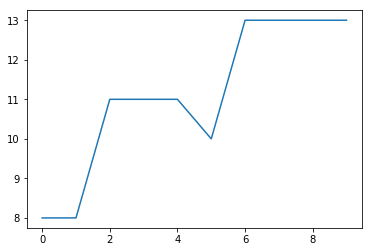

In [4]:
plot_max_cut_efficiency("maxcut/N010-id00.txt", 10, 1)

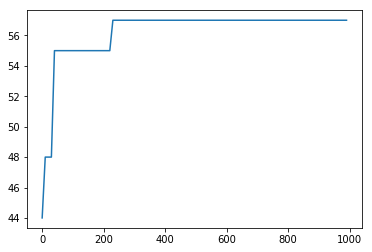

In [5]:
plot_max_cut_efficiency("maxcut/N020-id00.txt", 1000, 10)

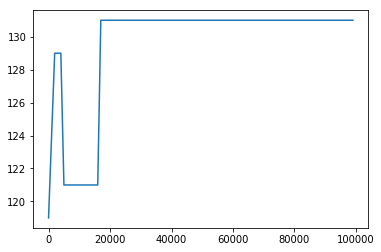

In [6]:
plot_max_cut_efficiency("maxcut/N030-id00.txt", 100000, 1000)

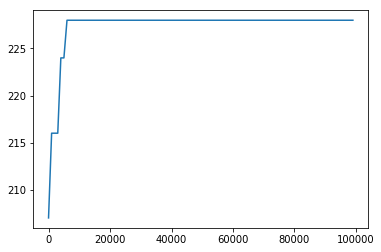

In [7]:
plot_max_cut_efficiency("maxcut/N040-id00.txt", 100000, 1000)

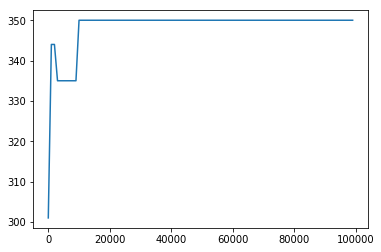

In [8]:
plot_max_cut_efficiency("maxcut/N050-id00.txt", 100000, 1000)

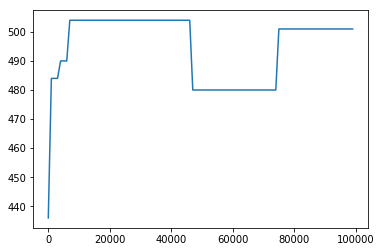

In [9]:
plot_max_cut_efficiency("maxcut/N060-id00.txt", 100000, 1000)

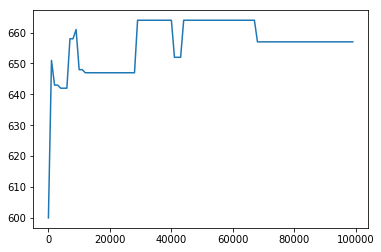

In [10]:
plot_max_cut_efficiency("maxcut/N070-id00.txt", 100000, 1000)

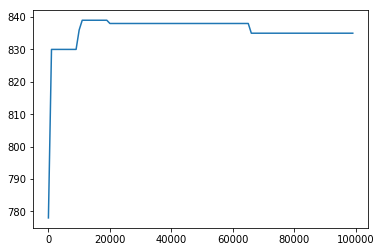

In [11]:
plot_max_cut_efficiency("maxcut/N080-id00.txt", 100000, 1000)

In [ ]:
plot_max_cut_efficiency("maxcut/N090-id00.txt", 100000, 1000)